In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
from spellchecker import SpellChecker

In [47]:
review = pd.read_csv("Park Review Data Set.csv")

In [49]:
# Assuming 'review' is your original DataFrame
review_clean = review[review.ne('\n').all(axis=1)]  # Filter out rows with only newline characters

# Reset the index to avoid skipping numbers
review_clean.reset_index(drop=True, inplace=True)

# Display the updated DataFrame description
review_clean.describe()


,Name,Date,Review,Park Name
count,2539,2539,2775,2539
unique,2353,28,2723,12
top,MusicMan Reviewer,5 years ago,Beautiful,Romare Bearden Park
freq,4,436,11,285


In [51]:

review_clean = pd.DataFrame(review_clean)

# Remove emojis and other non-text characters from the 'Review' column
review_clean['Review'] = review_clean['Review'].apply(lambda x: re.sub(r'[^\w\s,]', '', str(x)))  # Remove emojis/special chars

# Display the updated DataFrame



In [53]:
review_clean = pd.DataFrame(review_clean)

# Iterate through the DataFrame to merge reviews
last_valid_row = None  # To keep track of the last row with valid data

for i in range(1, len(review_clean)):
    # If the row has NaN for Name, Date, and Park Name, it should be merged with the last valid row
    if pd.isna(review_clean.loc[i, 'Name']) and pd.isna(review_clean.loc[i, 'Date']) and pd.isna(review_clean.loc[i, 'Park Name']):
        if last_valid_row is not None:
            # Append review to the last valid row's review
            review_clean.loc[last_valid_row, 'Review'] += " " + review_clean.loc[i, 'Review']
            # Drop the current row after merging reviews
            review_clean.drop(index=i, inplace=True)
    else:
        # Update last_valid_row to the current valid row
        last_valid_row = i

# Reset index to avoid gaps
review_clean.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
#display(review_clean)

In [54]:
# List of park names to remove
park_names = [
    "Romare Bearden Park", "Robert L. Smith Park", "Reedy Creek Park", "Park Road Park",
    "Nevin Park", "McAlpine Creek Park", "Little Sugar Creek Greenway", "Hornets Nest Park",
    "Freedom Park", "First Ward Park", "Fourth Ward Park", "UNCC Botanical Garden"
]


In [55]:

def remove_park_names(text):
    for park in park_names:
        text = re.sub(r'\b' + re.escape(park) + r'\b', '', text, flags=re.IGNORECASE)  # Remove park names
    return text.strip()  # Remove extra spaces

# Apply function to remove park names
review_clean['Review'] = review_clean['Review'].astype(str).apply(remove_park_names)

# Display before & after
display(review_clean[['Review']].head(10))


,Review
0,", located in Uptown Charlotte, is a beautifull..."
1,Wow stunning park well maintained horticultu...
2,Its a beautiful part and I was blessed to expe...
3,What an amazing park in Uptown Charlotte Big f...
4,"Great view , went there to see uptown Charlott..."
5,This park had the best views of downtown since...
6,"in Charlotte, North Carolina is an absolute ge..."
7,This place is perfect for relaxation and unwin...
8,is a beautiful urban oasis Located in the hear...
9,Absolute beautiful park Theres a huge field to...


In [58]:



spell = SpellChecker()

def correct_spelling_pyspell(text):
    words = text.split()
    corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
    return " ".join(corrected_words)

# Apply correction
review_clean['Review_Corrected'] = review_clean['Review'].astype(str).apply(correct_spelling_pyspell)

# Display before & after correction 
display(review_clean[['Review', 'Review_Corrected']].head(10))


,Review,Review_Corrected
0,", located in Uptown Charlotte, is a beautifull...",", located in Uptown charlotte is a beautifully..."
1,Wow stunning park well maintained horticultu...,Wow stunning park well maintained horticulture...
2,Its a beautiful part and I was blessed to expe...,Its a beautiful part and I was blessed to expe...
3,What an amazing park in Uptown Charlotte Big f...,What an amazing park in Uptown Charlotte Big f...
4,"Great view , went there to see uptown Charlott...","Great view , went there to see uptown Charlott..."
5,This park had the best views of downtown since...,This park had the best views of downtown since...
6,"in Charlotte, North Carolina is an absolute ge...",in charlotte North Carolina is an absolute gem...
7,This place is perfect for relaxation and unwin...,This place is perfect for relaxation and unwin...
8,is a beautiful urban oasis Located in the hear...,is a beautiful urban oasis Located in the hear...
9,Absolute beautiful park Theres a huge field to...,Absolute beautiful park there a huge field to ...


Cleaning Finished 

In [61]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])
    
review_clean[['Polarity', 'Subjectivity']] = review_clean['Review_Corrected'].apply(analyze_sentiment)


In [62]:
display(review_clean)

,Name,Date,Review,Park Name,Review_Corrected,Polarity,Subjectivity
0,Giovanni Cortes,2 months ago,", located in Uptown Charlotte, is a beautifull...",Romare Bearden Park,", located in Uptown charlotte is a beautifully...",0.190000,0.440000
1,LALITH KUMAR,6 months ago,Wow stunning park well maintained horticultu...,Romare Bearden Park,Wow stunning park well maintained horticulture...,0.475000,0.600000
2,Garrett Myler,6 months ago,Its a beautiful part and I was blessed to expe...,Romare Bearden Park,Its a beautiful part and I was blessed to expe...,0.275000,0.750000
3,Bruce K.,11 months ago,What an amazing park in Uptown Charlotte Big f...,Romare Bearden Park,What an amazing park in Uptown Charlotte Big f...,0.386905,0.584524
4,Bala Subramanian,3 months ago,"Great view , went there to see uptown Charlott...",Romare Bearden Park,"Great view , went there to see uptown Charlott...",0.483333,0.708333
...,...,...,...,...,...,...,...
2534,M & O Landscaping,a year ago,Beautiful place to learn and share with family,UNCC Botanical Garden,Beautiful place to learn and share with family,0.850000,1.000000
2535,Mary Moreno,5 years ago,Beautiful place with enough parking for disabl...,UNCC Botanical Garden,Beautiful place with enough parking for disabl...,0.162500,0.466667
2536,David Barragan,6 years ago,It is a small garden but it has a great variet...,UNCC Botanical Garden,It is a small garden but it has a great variet...,0.275000,0.575000
2537,Ines Jimenez,2 years ago,Beautiful,UNCC Botanical Garden,Beautiful,0.850000,1.000000


In [95]:
def classify_sentiment(polarity):
    if polarity > 0.25:
        return "Positive"
    elif polarity < -0.01:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment classification
review_clean['Sentiment'] = review_clean['Polarity'].apply(classify_sentiment)

# Check sentiment distribution
print(review_clean['Sentiment'].value_counts())


Sentiment
Positive    1868
Neutral      589
Negative      82
Name: count, dtype: int64


In [97]:
# Group by park name and calculate average polarity
park_sentiment = review_clean.groupby('Park Name')['Polarity'].mean().sort_values(ascending=False)

# Display top & bottom parks
print("Top 5 Happiest Parks:\n", park_sentiment.head(5))
print("\nTop 5 Most Criticized Parks:\n", park_sentiment.tail(5))


Top 5 Happiest Parks:
 Park Name
Freedom Park                   0.491607
Park Road Park                 0.463200
Romare Bearden Park            0.455879
Little Sugar Creek Greenway    0.436498
McAlpine Creek Park            0.424282
Name: Polarity, dtype: float64

Top 5 Most Criticized Parks:
 Park Name
Robert L. Smith Park     0.400504
Fourth Ward Park         0.397895
UNCC Botanical Garden    0.388221
Nevin Park               0.380472
First Ward Park          0.364099
Name: Polarity, dtype: float64


In [99]:
park_subjectivity = review_clean.groupby('Park Name')['Subjectivity'].mean().sort_values(ascending=False)

# Display most & least opinionated parks
print("Top 5 Most Opinionated Parks:\n", park_subjectivity.head(5))
print("\nTop 5 Most Fact-Based Parks:\n", park_subjectivity.tail(5))

Top 5 Most Opinionated Parks:
 Park Name
Freedom Park                   0.679625
Romare Bearden Park            0.676815
Park Road Park                 0.668159
Little Sugar Creek Greenway    0.652546
UNCC Botanical Garden          0.646667
Name: Subjectivity, dtype: float64

Top 5 Most Fact-Based Parks:
 Park Name
Robert L. Smith Park    0.630988
Fourth Ward Park        0.612939
Reedy Creek Park        0.610548
Hornets Nest Park       0.608974
Nevin Park              0.577972
Name: Subjectivity, dtype: float64


In [117]:
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get English stopwords and add custom ones
stop_words = set(stopwords.words('english'))
custom_stopwords = {"park", "charlotte", "one", "place", "get", "go", "place"}  # Add words you want to remove
stop_words.update(custom_stopwords)  # Combine default and custom stopwords

def clean_words(word_list):
    return [word.lower() for word in word_list if word.lower() not in stop_words]  # Lowercase & remove stopwords

# Extract words from positive & negative reviews
positive_words = " ".join(review_clean[review_clean['Sentiment'] == "Positive"]['Review']).split()
negative_words = " ".join(review_clean[review_clean['Sentiment'] == "Negative"]['Review']).split()

# Clean words (lowercase + stopword removal)
positive_words_cleaned = clean_words(positive_words)
negative_words_cleaned = clean_words(negative_words)

# Count word occurrences
positive_counts = Counter(positive_words_cleaned)
negative_counts = Counter(negative_words_cleaned)

print("Top Positive Words:\n", positive_counts.most_common(10))
print("\nTop Negative Words:\n", negative_counts.most_common(10))


Top Positive Words:
 [('great', 577), ('nice', 508), ('beautiful', 491), ('walk', 253), ('good', 231), ('kids', 223), ('love', 212), ('family', 179), ('area', 175), ('well', 174)]

Top Negative Words:
 [('people', 18), ('area', 16), ('small', 16), ('around', 14), ('dog', 13), ('disc', 13), ('also', 12), ('walk', 11), ('parking', 11), ('homeless', 10)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jdric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def extract_ngrams_by_sentiment(df, column_name, sentiment_column):
    """
    This function processes reviews by sentiment, and extracts top bigrams and trigrams.
    
    Args:
    - df (DataFrame): The dataframe containing reviews and sentiment.
    - column_name (str): The name of the review column (e.g., 'Review').
    - sentiment_column (str): The name of the sentiment column (e.g., 'Sentiment').
    
    Returns:
    - A dictionary with top bigrams and trigrams for each sentiment category.
    """
    # Initialize the vectorizer for bigrams and trigrams
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    trigram_vectorizer = CountVectorizer(ngram_range=(4, 4), stop_words='english')

    # Initialize dictionary to store results
    ngram_results = {}

    # Loop through each sentiment category (positive, negative, neutral)
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        # Filter reviews by sentiment
        sentiment_reviews = df[df[sentiment_column] == sentiment][column_name].dropna().tolist()

        # Fit and transform for bigrams and trigrams
        bigram_matrix = bigram_vectorizer.fit_transform(sentiment_reviews)
        trigram_matrix = trigram_vectorizer.fit_transform(sentiment_reviews)

        # Count frequencies of bigrams & trigrams
        bigram_counts = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
        trigram_counts = pd.DataFrame(trigram_matrix.toarray(), columns=trigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

        # Store the results in the dictionary
        ngram_results[sentiment] = {
            'Top 10 Bigrams': bigram_counts.head(10),
            'Top 10 Trigrams': trigram_counts.head(10)
        }
    
    return ngram_results

# Example usage of the function
ngram_analysis = extract_ngrams_by_sentiment(review_clean, 'Review_Corrected', 'Sentiment')

# Print the results
for sentiment, results in ngram_analysis.items():
    print(f"Top Bigrams and Trigrams for {sentiment} Reviews:\n")
    print("Top 10 Bigrams:\n", results['Top 10 Bigrams'])
    print("\nTop 10 Trigrams:\n", results['Top 10 Trigrams'])
    print("\n" + "="*40 + "\n")


Top Bigrams and Trigrams for Positive Reviews:

Top 10 Bigrams:
 great place        148
beautiful park     106
nice park          100
great park          93
disc golf           79
nice place          76
beautiful place     65
place walk          61
golf course         59
dog park            51
dtype: int64

Top 10 Trigrams:
 great disc golf course          6
challenging disc golf course    5
great place walk dog            5
awesome disc golf course        5
nice disc golf course           4
spend time family friends       3
best disc golf courses          3
great place bring kids          3
great place spend time          3
love park beautiful place       3
dtype: int64


Top Bigrams and Trigrams for Negative Reviews:

Top 10 Bigrams:
 disc golf          10
dog park           10
golf course         7
small park          6
public library      3
green space         3
area walk           3
homeless people     3
20 labs             3
dogs 20             2
dtype: int64

Top 10 Trigrams:
 d

In [140]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

def extract_adjectives_nltk(text):
    words = word_tokenize(text.lower())
    tagged_words = pos_tag(words)
    adjectives = [word for word, tag in tagged_words if tag in ['JJ', 'JJR', 'JJS']]  # JJ, JJR, JJS are adjective tags
    return adjectives

# Apply to reviews
review_clean['Adjectives'] = review_clean['Review_Corrected'].apply(extract_adjectives_nltk)

# Show first few results
print(review_clean[['Review_Corrected', 'Adjectives']].head(10))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jdric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jdric\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jdric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                    Review_Corrected  \
0  , located in Uptown charlotte is a beautifully...   
1  Wow stunning park well maintained horticulture...   
2  Its a beautiful part and I was blessed to expe...   
3  What an amazing park in Uptown Charlotte Big f...   
4  Great view , went there to see uptown Charlott...   
5  This park had the best views of downtown since...   
6  in charlotte North Carolina is an absolute gem...   
7  This place is perfect for relaxation and unwin...   
8  is a beautiful urban oasis Located in the hear...   
9  Absolute beautiful park there a huge field to ...   

                                          Adjectives  
0         [uptown, urban, green, local, interactive]  
1                                [maintained, smell]  
2             [beautiful, late, only, enough, trash]  
3  [amazing, uptown, big, flat, huge, super, awes...  
4  [great, uptown, adjacent, decorative, lighted,...  
5                            [best, smack, homeless] 

In [254]:
# Define park features to extract directly from reviews
park_features = ["bathroom", "benches", "disc golf", "playground", "parking", "trail", "lawn", "cleanliness", "safety", "water fountain", "people"]

# Function to extract features from reviews
def extract_features_from_review(review, features):
    found_features = []
    for feature in features:
        if feature in review.lower():  # Case insensitive matching
            found_features.append(feature)
    return found_features

# Apply the function to extract features from each review
review_clean['Extracted_Features'] = review_clean['Review_Corrected'].apply(lambda x: extract_features_from_review(x, park_features))

# Show the extracted features for the first few reviews
print(review_clean[['Review_Corrected', 'Extracted_Features']].head(10))


                                    Review_Corrected Extracted_Features
0  , located in Uptown charlotte is a beautifully...             [lawn]
1  Wow stunning park well maintained horticulture...                 []
2  Its a beautiful part and I was blessed to expe...                 []
3  What an amazing park in Uptown Charlotte Big f...                 []
4  Great view , went there to see uptown Charlott...                 []
5  This park had the best views of downtown since...           [people]
6  in charlotte North Carolina is an absolute gem...                 []
7  This place is perfect for relaxation and unwin...                 []
8  is a beautiful urban oasis Located in the hear...   [water fountain]
9  Absolute beautiful park there a huge field to ...          [benches]


In [256]:
# Flatten 'Extracted_Features' and count feature occurrences in one line
feature_counts_df = review_clean['Extracted_Features'].explode().value_counts().reset_index(name="Count").rename(columns={"index": "Feature"})

# Display the feature counts
print(feature_counts_df)


   Extracted_Features  Count
0               trail    353
1          playground    251
2              people    172
3             parking    158
4           disc golf    121
5            bathroom     65
6             benches     57
7      water fountain     25
8                lawn     14
9              safety     10
10        cleanliness      5


In [258]:
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Function to extract adjectives within a 1-5 word window of a feature
def extract_adjectives_near_feature(text, feature, window=3):
    words = word_tokenize(text.lower())  # Tokenize the review
    tagged_words = pos_tag(words)  # POS tagging
    
    adjectives = []  # To store adjectives
    feature_positions = [i for i, word in enumerate(words) if feature in word]  # Find positions of the feature in the review
    
    for pos in feature_positions:
        # Define the window (1-5 words around the feature)
        start = max(0, pos - window)
        end = min(len(words), pos + window + 1)
        
        # Extract adjectives within the window
        for i in range(start, end):
            word, tag = tagged_words[i]
            if tag in ['JJ', 'JJR', 'JJS']:  # If it's an adjective
                adjectives.append(word)
    
    return adjectives

# Apply the function to each review for each feature
def extract_features_with_adjectives(row, features, window=5):
    review = row['Review_Corrected']
    feature_adjectives = {}
    
    for feature in features:
        adjectives = extract_adjectives_near_feature(review, feature, window)
        if adjectives:
            feature_adjectives[feature] = adjectives  # Store adjectives for the feature
    
    return feature_adjectives

# Define the park features you're interested in
park_features = ["bathroom", "benches", "disc golf", "playground", "parking", "trail", "lawn", "cleanliness", "safety", "water fountain"]

# Apply the function to the reviews
review_clean['Feature_Adjectives'] = review_clean.apply(lambda row: extract_features_with_adjectives(row, park_features), axis=1)

# Show the first few rows of Feature_Adjectives
print(review_clean[['Review_Corrected', 'Feature_Adjectives']].head(10))


                                    Review_Corrected  \
0  , located in Uptown charlotte is a beautifully...   
1  Wow stunning park well maintained horticulture...   
2  Its a beautiful part and I was blessed to expe...   
3  What an amazing park in Uptown Charlotte Big f...   
4  Great view , went there to see uptown Charlott...   
5  This park had the best views of downtown since...   
6  in charlotte North Carolina is an absolute gem...   
7  This place is perfect for relaxation and unwin...   
8  is a beautiful urban oasis Located in the hear...   
9  Absolute beautiful park there a huge field to ...   

          Feature_Adjectives  
0  {'lawn': ['interactive']}  
1                         {}  
2                         {}  
3                         {}  
4                         {}  
5                         {}  
6                         {}  
7                         {}  
8                         {}  
9       {'benches': ['fur']}  


In [259]:
from collections import Counter

# Flatten the lists in the 'Feature_Adjectives' column and count the occurrences
all_feature_adjectives = [adj for feature_dict in review_clean['Feature_Adjectives'] for adj_list in feature_dict.values() for adj in adj_list]

# Count the occurrences of each adjective
adjective_counts = Counter(all_feature_adjectives)

# Convert to a DataFrame for easier visualization
adjective_counts_df = pd.DataFrame(adjective_counts.items(), columns=["Adjective", "Count"]).sort_values(by="Count", ascending=False)

# Display the top adjectives
print(adjective_counts_df.head(10))


    Adjective  Count
29      great    110
14       nice     97
38       good     50
21  beautiful     40
46      clean     38
55     picnic     35
5       large     34
3         big     33
43       many     30
11  available     24


In [260]:
# Count adjectives for each feature separately
feature_adjective_counts = {}

for feature in park_features:
    feature_adjectives = [adj for feature_dict in review_clean['Feature_Adjectives'] for feature, adj_list in feature_dict.items() if feature == feature for adj in adj_list]
    feature_adjective_counts[feature] = Counter(feature_adjectives)

# Display the top adjectives for each feature
for feature, counts in feature_adjective_counts.items():
    print(f"Top Adjectives for '{feature}':")
    print(counts.most_common(10))
    print("\n")


Top Adjectives for 'bathroom':
[('great', 110), ('nice', 97), ('good', 50), ('beautiful', 40), ('clean', 38), ('picnic', 35), ('large', 34), ('big', 33), ('many', 30), ('available', 24)]


Top Adjectives for 'benches':
[('great', 110), ('nice', 97), ('good', 50), ('beautiful', 40), ('clean', 38), ('picnic', 35), ('large', 34), ('big', 33), ('many', 30), ('available', 24)]


Top Adjectives for 'disc golf':
[('great', 110), ('nice', 97), ('good', 50), ('beautiful', 40), ('clean', 38), ('picnic', 35), ('large', 34), ('big', 33), ('many', 30), ('available', 24)]


Top Adjectives for 'playground':
[('great', 110), ('nice', 97), ('good', 50), ('beautiful', 40), ('clean', 38), ('picnic', 35), ('large', 34), ('big', 33), ('many', 30), ('available', 24)]


Top Adjectives for 'parking':
[('great', 110), ('nice', 97), ('good', 50), ('beautiful', 40), ('clean', 38), ('picnic', 35), ('large', 34), ('big', 33), ('many', 30), ('available', 24)]


Top Adjectives for 'trail':
[('great', 110), ('nice', 

In [276]:
# Create an empty dictionary to store adjectives by feature and sentiment
feature_adjective_counts_by_sentiment = {}

# Define the park features you're interested in
park_features = ["bathroom", "benches", "playground", "parking", "trail", "lawn" "disc golf", "water fountain", "safety", "cleanliness", "people" ]

# Loop through the park features and sentiment categories
for feature in park_features:
    feature_adjective_counts_by_sentiment[feature] = {"Positive": [], "Negative": [], "Neutral": []}
    
    # Loop through the reviews and separate by sentiment
    for index, row in review_clean.iterrows():
        review_sentiment = row['Sentiment']  # Get the sentiment of the review
        feature_adjectives = row['Feature_Adjectives'].get(feature, [])  # Get adjectives for the current feature

        # Append adjectives to the corresponding sentiment category
        if review_sentiment in feature_adjective_counts_by_sentiment[feature]:
            feature_adjective_counts_by_sentiment[feature][review_sentiment].extend(feature_adjectives)

# Count the occurrences of adjectives for each feature and sentiment
feature_adjective_counts_by_sentiment_final = {}

for feature, sentiment_data in feature_adjective_counts_by_sentiment.items():
    feature_adjective_counts_by_sentiment_final[feature] = {}
    for sentiment, adjectives in sentiment_data.items():
        feature_adjective_counts_by_sentiment_final[feature][sentiment] = Counter(adjectives)

# Display the counts of adjectives for each feature and sentiment
for feature, sentiment_data in feature_adjective_counts_by_sentiment_final.items():
    print(f"Adjectives for '{feature}':")
    for sentiment, counts in sentiment_data.items():
        print(f"  Sentiment: {sentiment}")
        print(counts.most_common(5))  # Show top 5 adjectives
    print("\n")


Adjectives for 'bathroom':
  Sentiment: Positive
[('clean', 11), ('nice', 6), ('good', 5), ('great', 3), ('picnic', 3)]
  Sentiment: Negative
[('i', 1), ('usable', 1), ('old', 1), ('homeless', 1), ('nasty', 1)]
  Sentiment: Neutral
[('available', 3), ('good', 2), ('picnic', 2), ('open', 2), ('clean', 2)]


Adjectives for 'benches':
  Sentiment: Positive
[('picnic', 6), ('nice', 4), ('beautiful', 3), ('many', 3), ('fountain', 2)]
  Sentiment: Negative
[('other', 1)]
  Sentiment: Neutral
[('picnic', 1), ('little', 1), ('many', 1), ('short', 1), ('available', 1)]


Adjectives for 'playground':
  Sentiment: Positive
[('great', 37), ('nice', 19), ('good', 12), ('large', 11), ('big', 9)]
  Sentiment: Negative
[('new', 2), ('smaller', 2), ('multiple', 1), ('little', 1), ('many', 1)]
  Sentiment: Neutral
[('large', 6), ('big', 6), ('small', 5), ('nice', 4), ('little', 4)]


Adjectives for 'parking':
  Sentiment: Positive
[('free', 15), ('available', 12), ('great', 9), ('nice', 8), ('easy', 7)]

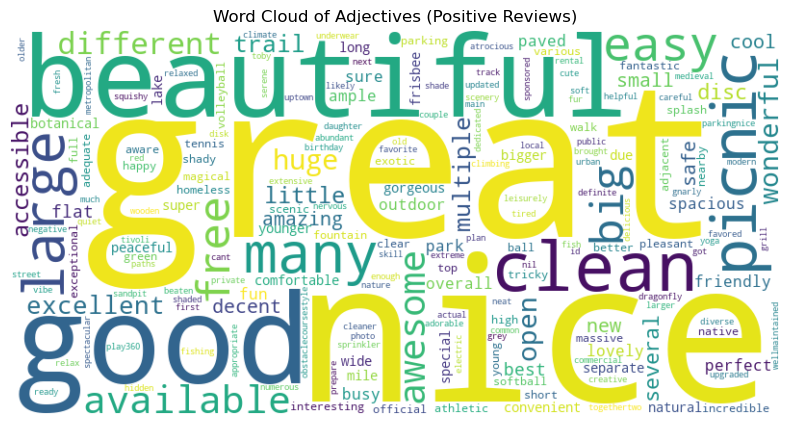

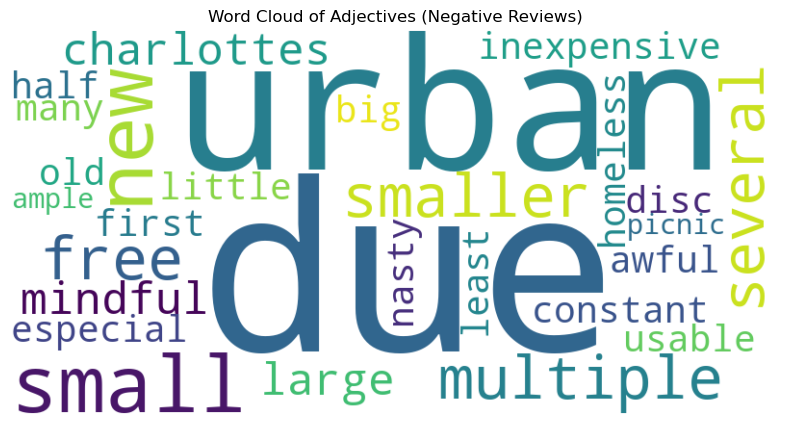

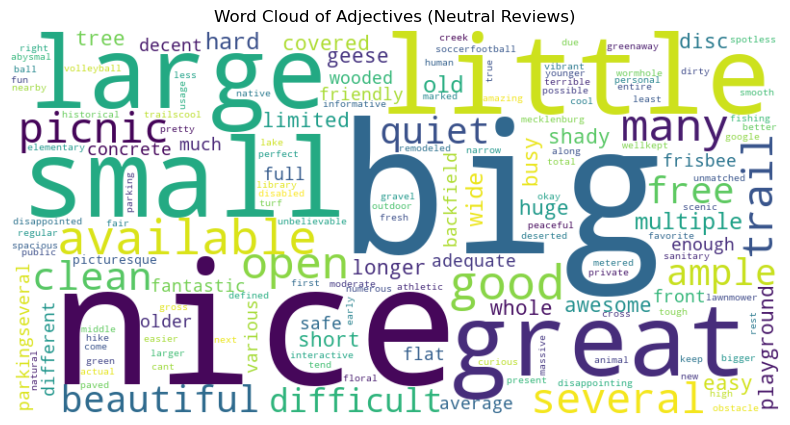

In [278]:
from wordcloud import WordCloud

# Function to generate a word cloud for a given sentiment
def generate_wordcloud(sentiment):
    adjectives = [adj for feature_dict in review_clean[review_clean['Sentiment'] == sentiment]['Feature_Adjectives'] 
                  for adj_list in feature_dict.values() for adj in adj_list]
    text = " ".join(adjectives)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud of Adjectives ({sentiment} Reviews)")
    plt.axis("off")
    plt.show()

# Generate for each sentiment
for sentiment in ["Positive", "Negative", "Neutral"]:
    generate_wordcloud(sentiment)


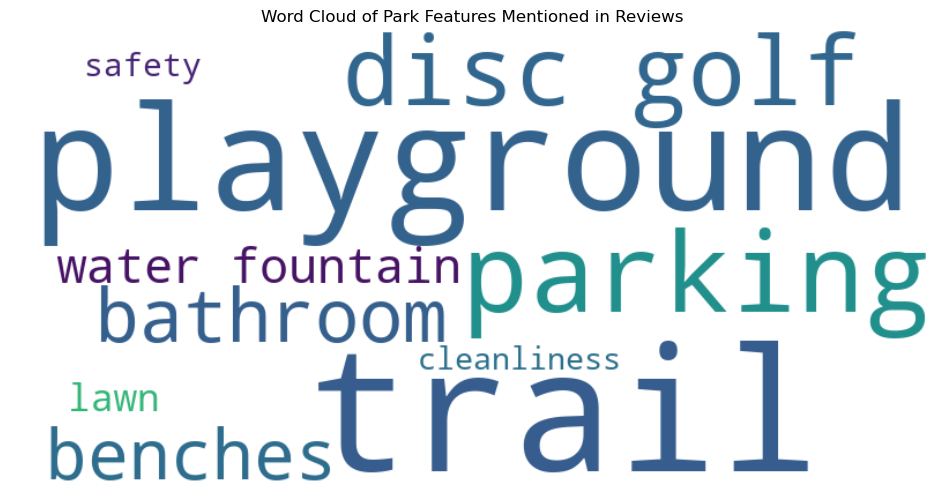

In [279]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert feature counts into a dictionary
feature_counts_dict = {
    "trail": 353, "playground": 251, "parking": 158, "disc golf": 121, 
    "bathroom": 65, "benches": 57, "water fountain": 25, "lawn": 14, 
    "safety": 10, "cleanliness": 9
}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(feature_counts_dict)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud of Park Features Mentioned in Reviews")
plt.show()


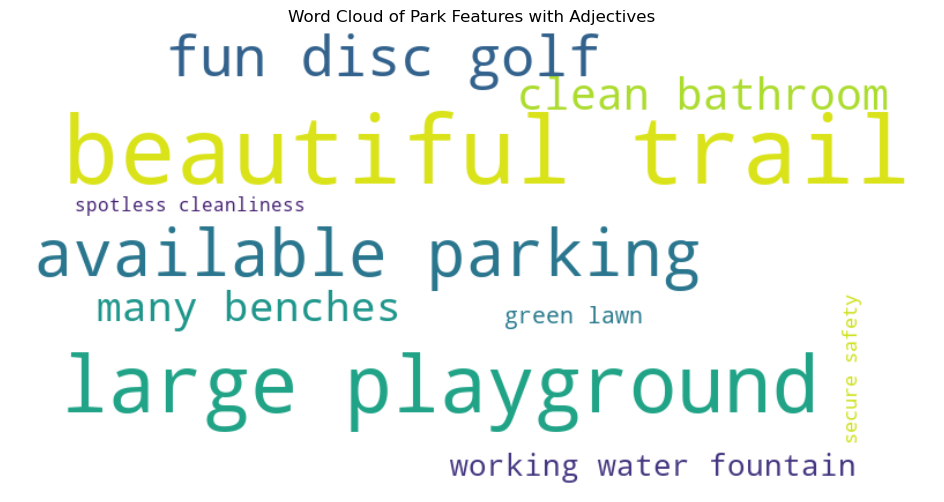

In [280]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Feature-Adjective Mapping (Replace with real data)
feature_adjective_counts = {
    "trail": ("beautiful", 353), 
    "playground": ("large", 251), 
    "parking": ("available", 158), 
    "disc golf": ("fun", 121), 
    "bathroom": ("clean", 65), 
    "benches": ("many", 57), 
    "water fountain": ("working", 25), 
    "lawn": ("green", 14), 
    "safety": ("secure", 10), 
    "cleanliness": ("spotless", 9)
}

# Convert to a word cloud-friendly format
feature_adjective_dict = {f"{adj} {feature}": count for feature, (adj, count) in feature_adjective_counts.items()}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(feature_adjective_dict)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Park Features with Adjectives")
plt.show()


In [265]:
from collections import Counter

# Flatten the adjectives list and count occurrences
all_adjectives = [adj for feature_dict in review_clean['Feature_Adjectives'] 
                  for adj_list in feature_dict.values() for adj in adj_list]

# Get the top 10 adjectives used in the dataset
top_10_adjectives = [adj for adj, _ in Counter(all_adjectives).most_common(10)]

# Display the selected adjectives
print("Top 10 Adjectives:", top_10_adjectives)


Top 10 Adjectives: ['great', 'nice', 'good', 'beautiful', 'clean', 'picnic', 'large', 'big', 'many', 'available']


In [266]:
# Flatten the data
flattened_data = []

for feature, sentiment_data in feature_adjective_counts_by_sentiment_final.items():
    for sentiment, counts in sentiment_data.items():
        for adj, count in counts.items():
            if adj in top_10_adjectives:  # Only keep top 10 adjectives
                flattened_data.append([feature, sentiment, adj, count])

# Convert to DataFrame
df_filtered = pd.DataFrame(flattened_data, columns=["Feature", "Sentiment", "Adjective", "Count"])

# Display the first few rows
print(df_filtered.head())


    Feature Sentiment Adjective  Count
0  bathroom  Positive     clean     11
1  bathroom  Positive     great      3
2  bathroom  Positive      good      5
3  bathroom  Positive     large      2
4  bathroom  Positive    picnic      3


C:\Users\jdric\AppData\Local\Temp\ipykernel_24856\3871855227.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


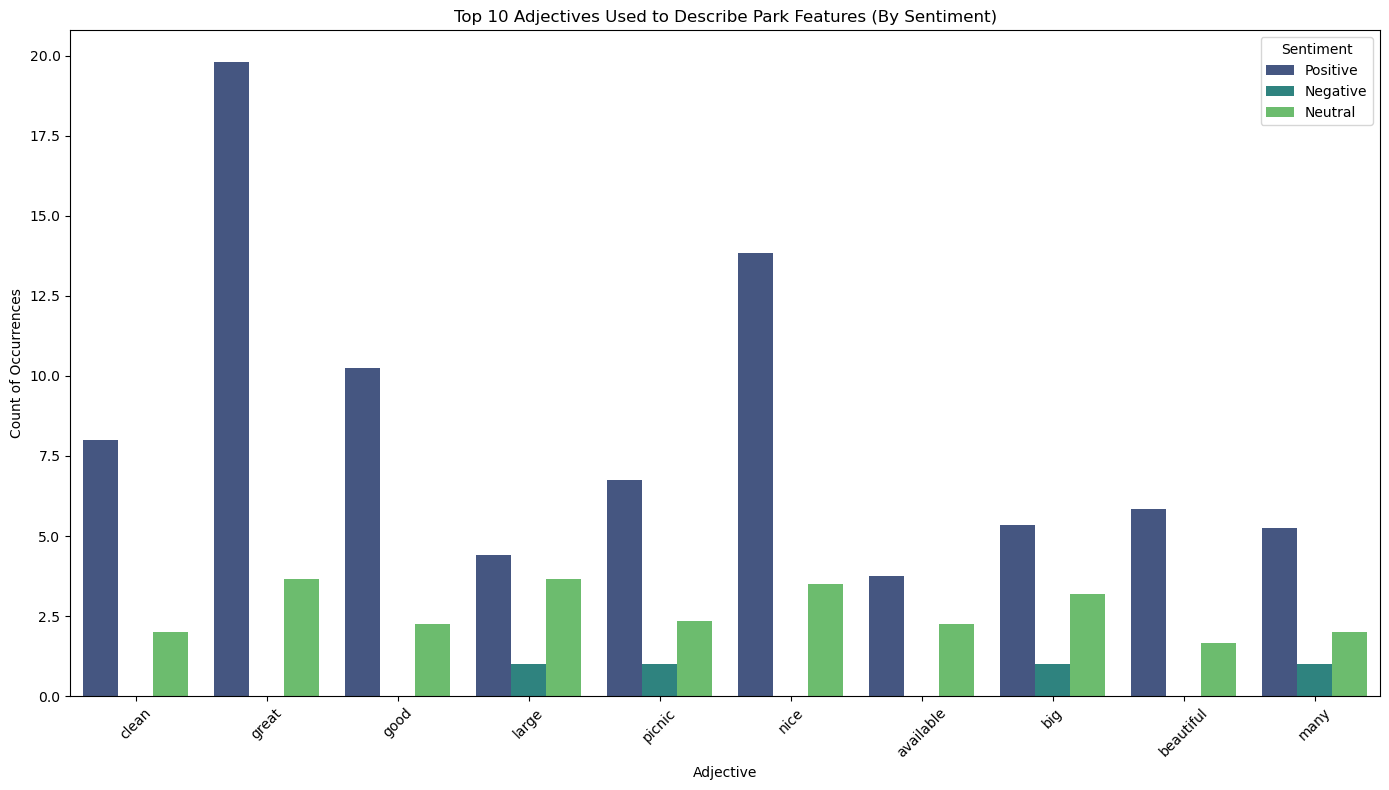

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(14, 8))

# Create a grouped bar plot for top adjectives across sentiments
sns.barplot(
    data=df_filtered,
    x="Adjective",
    y="Count",
    hue="Sentiment",
    ci=None,
    palette="viridis"
)

plt.title("Top 10 Adjectives Used to Describe Park Features (By Sentiment)")
plt.xlabel("Adjective")
plt.ylabel("Count of Occurrences")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


C:\Users\jdric\AppData\Local\Temp\ipykernel_24856\2593362018.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\jdric\AppData\Local\Temp\ipykernel_24856\2593362018.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\jdric\AppData\Local\Temp\ipykernel_24856\2593362018.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\jdric\AppData\Local\Temp\ipykernel_24856\2593362018.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\jdric\AppData\Local\Temp\ipykernel_24856\2593362018.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `

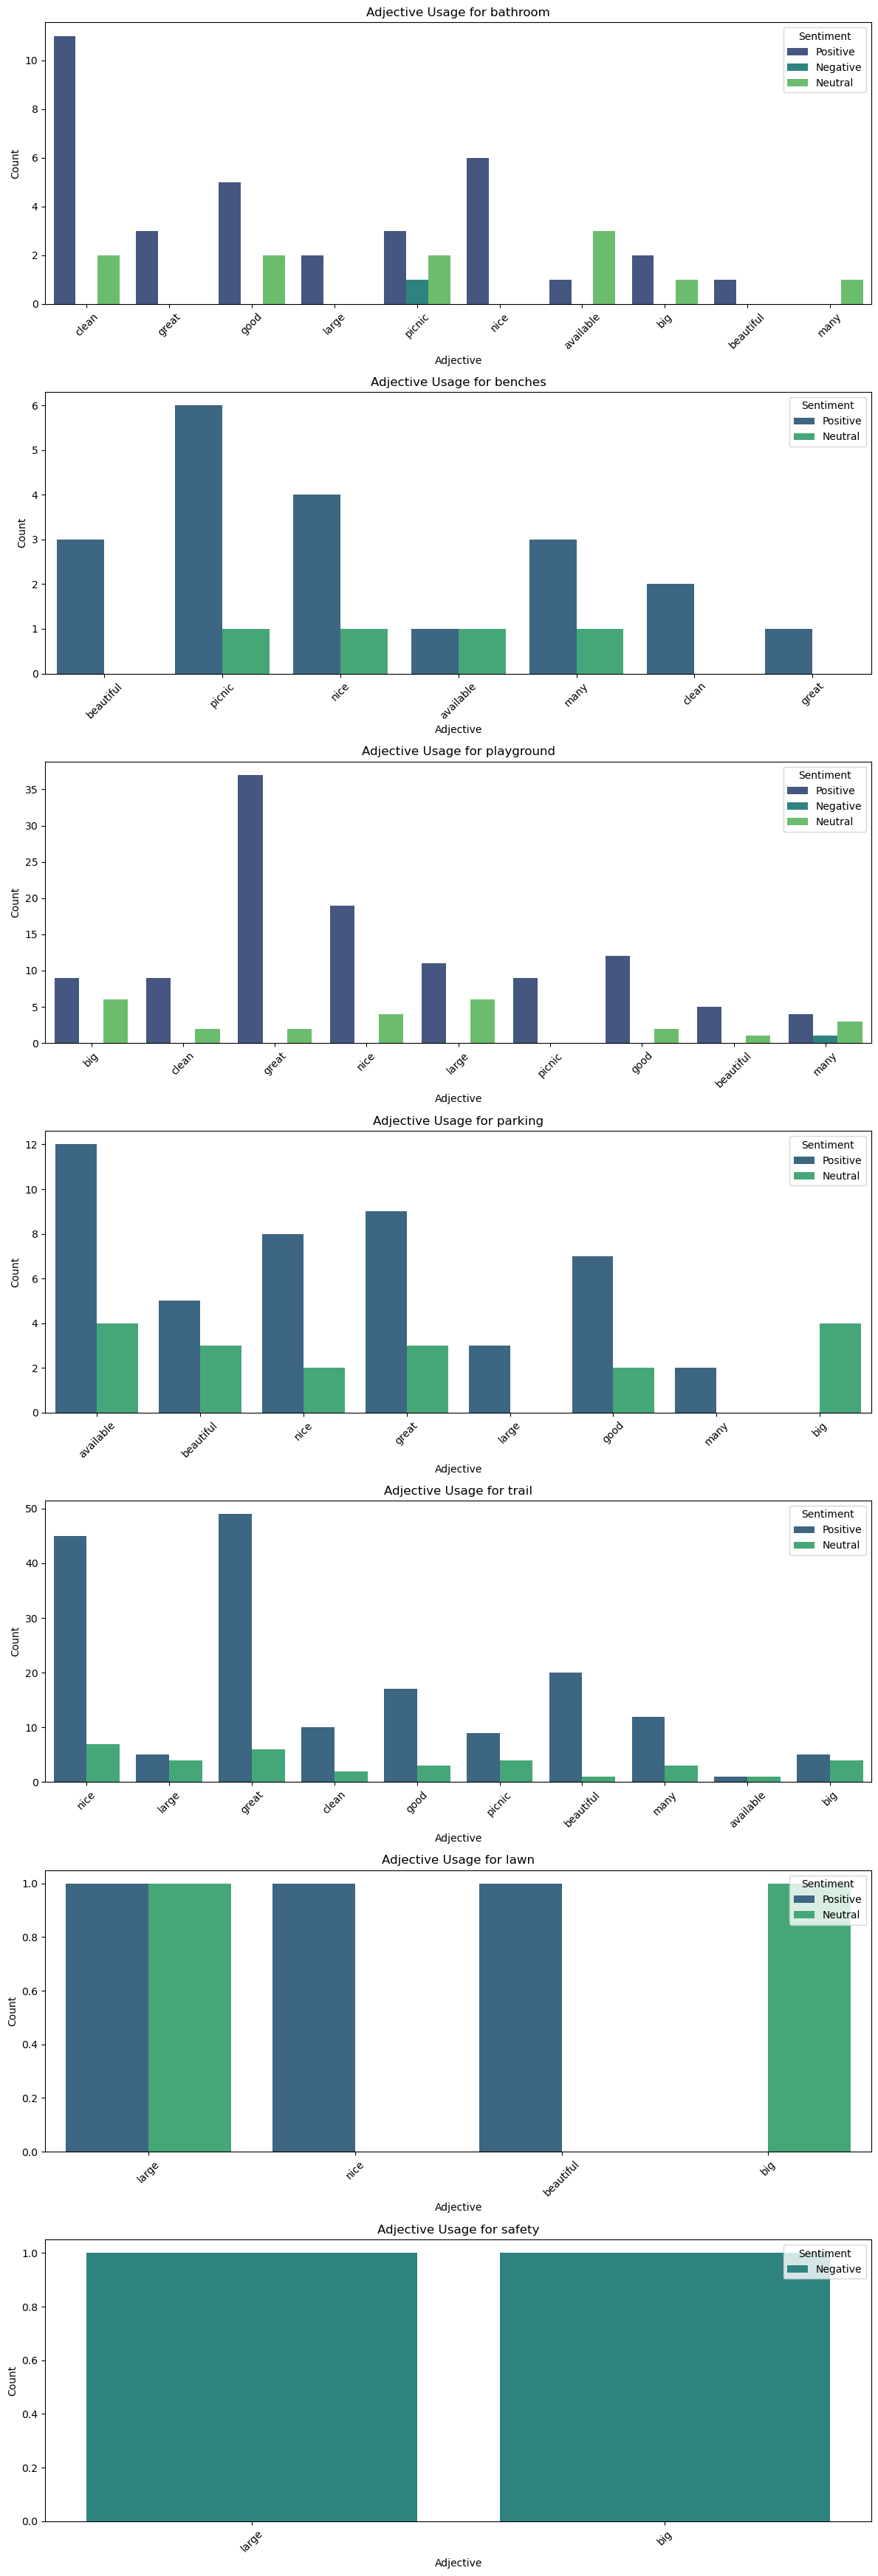

In [224]:
# Unique features in the dataset
features = df_filtered["Feature"].unique()

# Set up subplots
fig, axes = plt.subplots(len(features), 1, figsize=(12, len(features) * 5))

# Loop through features and create separate plots
for i, feature in enumerate(features):
    subset = df_filtered[df_filtered["Feature"] == feature]
    
    sns.barplot(
        data=subset,
        x="Adjective",
        y="Count",
        hue="Sentiment",
        ci=None,
        palette="viridis",
        ax=axes[i]
    )
    
    axes[i].set_title(f"Adjective Usage for {feature}")
    axes[i].set_xlabel("Adjective")
    axes[i].set_ylabel("Count")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].legend(title="Sentiment")

plt.tight_layout()
plt.show()
